In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [35]:
from olist.data import Olist
from olist.seller import Seller
from olist.order import Order

In [36]:
df_orders = Order().get_training_data(with_distance_seller_customer=True)
df_sellers = Seller().get_training_data()

In [37]:
data = Olist().get_data()
data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  

In [38]:
df_sellers["sales_fee"] = 0.1 * df_sellers["sales"]
"{:,.2f} BRL".format(df_sellers["sales_fee"].sum())

'1,355,578.44 BRL'

**Subscription fees:** Olist charges **80 BRL by month** per seller

In [39]:
df_sellers["monthly_fee"] = 80 * np.where(df_sellers["months_on_olist"] == 0, 1, df_sellers["months_on_olist"])
"{:,.2f} BRL".format(df_sellers["monthly_fee"].sum())

'1,480,000.00 BRL'

**Total Revenue**

In [40]:
df_sellers["total_revenue"] = df_sellers["sales_fee"] + df_sellers["monthly_fee"]
"{:,.2f} BRL".format(df_sellers["total_revenue"].sum())

'2,835,578.44 BRL'

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```


**Reputation costs**

In [54]:
"{:,.2f} BRL".format(df_sellers["review_cost"].sum())

'1,976,650.00 BRL'

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

**Total Cumulated IT Costs**

In [55]:
df_order_items = data["order_items"].copy()
df_products = data["products"].copy()

In [56]:
df_products["product_id"].nunique()

32951

In [60]:
n_sellers

2967

In [61]:
n_products

112650

In [59]:
# number of sellers
n_sellers = df_sellers["seller_id"].nunique()

# number of products
n_products = df_order_items["product_id"].count()

𝛼=3157.27 
𝛽=978.23

IT_costs = 𝛼*(n_sellers**0.5) + 𝛽*(n_products**0.5)
"{:,.2f} BRL".format(IT_costs)

'500,304.03 BRL'

In [64]:
IT_costs_ex1 = 𝛼*(1000**0.5) + 𝛽*(100**0.5)
"{:,.2f} BRL".format(IT_costs_ex1)

'109,623.94 BRL'

In [63]:
IT_costs_ex2 = 𝛼*(100**0.5) + 𝛽*(1000**0.5)
"{:,.2f} BRL".format(IT_costs_ex2)

'62,507.05 BRL'

In [62]:
# Check if there is any null number
df_sellers["months_on_olist"].isnull().values.any()

False

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

In [76]:
# Sellers have review_score = 1
revenue_sellers_score_1 = df_sellers[df_sellers["review_score"].between(0, 2)].groupby(["seller_state"], as_index = False)[["n_orders", "seller_state", "total_revenue"]].sum()

# # Sellers have review_score = 2
revenue_sellers_score_2 = df_sellers[df_sellers["review_score"].between(2, 3)].groupby(["seller_state"], as_index = False)[["n_orders", "seller_state", "total_revenue"]].sum()

# # Sellers have review_score = 3
revenue_sellers_score_3 = df_sellers[df_sellers["review_score"].between(3, 4)].groupby(["seller_state"], as_index = False)[["n_orders", "seller_state", "total_revenue"]].sum()

# # Under Performing Sellers
revenue_sellers_score = df_sellers[df_sellers["review_score"].between(0, 4)].groupby(["seller_state"], as_index = False)[["n_orders", "seller_state", "total_revenue"]].sum()

# All Sellers
revenue_allsellers_score = df_sellers.groupby(["seller_state"], as_index = False)[["n_orders", "seller_state", "total_revenue"]].sum()


In [69]:
# Sellers have review_score = 1
count_sellers_score_1 = df_sellers[df_sellers["review_score"].between(0, 2)]["seller_id"].nunique()
cost_sellers_score_1 = df_sellers[df_sellers["review_score"].between(0, 2)].groupby(["seller_state"], as_index = False)[["review_cost", "seller_state"]].sum()

state_sellers_score_1 = df_sellers[df_sellers["review_score"].between(0, 2)].groupby(["seller_state"], as_index = False).count()[["review_score","seller_state"]]
revenue_sellers_score_1 = df_sellers[df_sellers["review_score"].between(0, 2)].groupby(["seller_state"], as_index = False).sum()[["total_revenue","seller_state","review_cost"]]

df_merged_cost_state_1 = state_sellers_score_1.merge(cost_sellers_score_1, on="seller_state")
df_merged_cost_state_1 = df_merged_cost_state_1.merge(revenue_sellers_score_1, on="seller_state")

# Sellers have review_score = 2
count_sellers_score_2 = df_sellers[df_sellers["review_score"].between(2, 3)]["seller_id"].nunique()
cost_sellers_score_2 = df_sellers[df_sellers["review_score"].between(2, 3)].groupby(["seller_state"], as_index = False)[["review_cost", "seller_state"]].sum()

state_sellers_score_2 = df_sellers[df_sellers["review_score"].between(2, 3)].groupby(["seller_state"], as_index = False).count()[["review_score","seller_state"]]
revenue_sellers_score_2 = df_sellers[df_sellers["review_score"].between(2, 3)].groupby(["seller_state"], as_index = False).sum()[["total_revenue","seller_state","review_cost"]]

df_merged_cost_state_2 = state_sellers_score_2.merge(cost_sellers_score_2, on="seller_state")
df_merged_cost_state_2 = df_merged_cost_state_2.merge(revenue_sellers_score_2, on="seller_state")

# Sellers have review_score = 3
count_sellers_score_3 = df_sellers[df_sellers["review_score"].between(3, 4)]["seller_id"].nunique()
cost_sellers_score_3 = df_sellers[df_sellers["review_score"].between(3, 4)].groupby(["seller_state"], as_index = False)[["review_cost", "seller_state"]].sum()

state_sellers_score_3 = df_sellers[df_sellers["review_score"].between(3, 4)].groupby(["seller_state"], as_index = False).count()[["review_score","seller_state"]]
revenue_sellers_score_3 = df_sellers[df_sellers["review_score"].between(3, 4)].groupby(["seller_state"], as_index = False).sum()[["total_revenue","seller_state","review_cost"]]

df_merged_cost_state_3 = state_sellers_score_3.merge(cost_sellers_score_3, on="seller_state")
df_merged_cost_state_3 = df_merged_cost_state_3.merge(revenue_sellers_score_3, on="seller_state")

# Under Performing Sellers
count_badsellers_score = df_sellers[df_sellers["review_score"].between(0, 4)]["seller_id"].nunique()
cost_badsellers_score = df_sellers[df_sellers["review_score"].between(0, 4)].groupby(["seller_state"], as_index = False)[["review_cost", "seller_state"]].sum()

state_badsellers_score = df_sellers[df_sellers["review_score"].between(0, 4)].groupby(["seller_state"], as_index = False).count()[["review_score","seller_state"]]
revenue_badsellers_score = df_sellers[df_sellers["review_score"].between(0, 4)].groupby(["seller_state"], as_index = False).sum()[["total_revenue","seller_state","review_cost"]]

df_merged_cost_state = state_badsellers_score.merge(cost_badsellers_score, on="seller_state")
df_merged_cost_state = df_merged_cost_state.merge(revenue_badsellers_score, on="seller_state")

# All Sellers
count_allsellers_score = df_sellers["seller_id"].nunique()
cost_allsellers_score = df_sellers.groupby(["seller_state"], as_index = False)[["review_cost", "seller_state"]].sum()

state_allsellers_score = df_sellers.groupby(["seller_state"], as_index = False).count()[["review_score","seller_state"]]
revenue_allsellers_score = df_sellers.groupby(["seller_state"], as_index = False).sum()[["total_revenue","seller_state"]]

df_merged_allcost_state = state_allsellers_score.merge(cost_allsellers_score, on="seller_state")
df_merged_allcost_state = df_merged_allcost_state.merge(revenue_allsellers_score, on="seller_state")


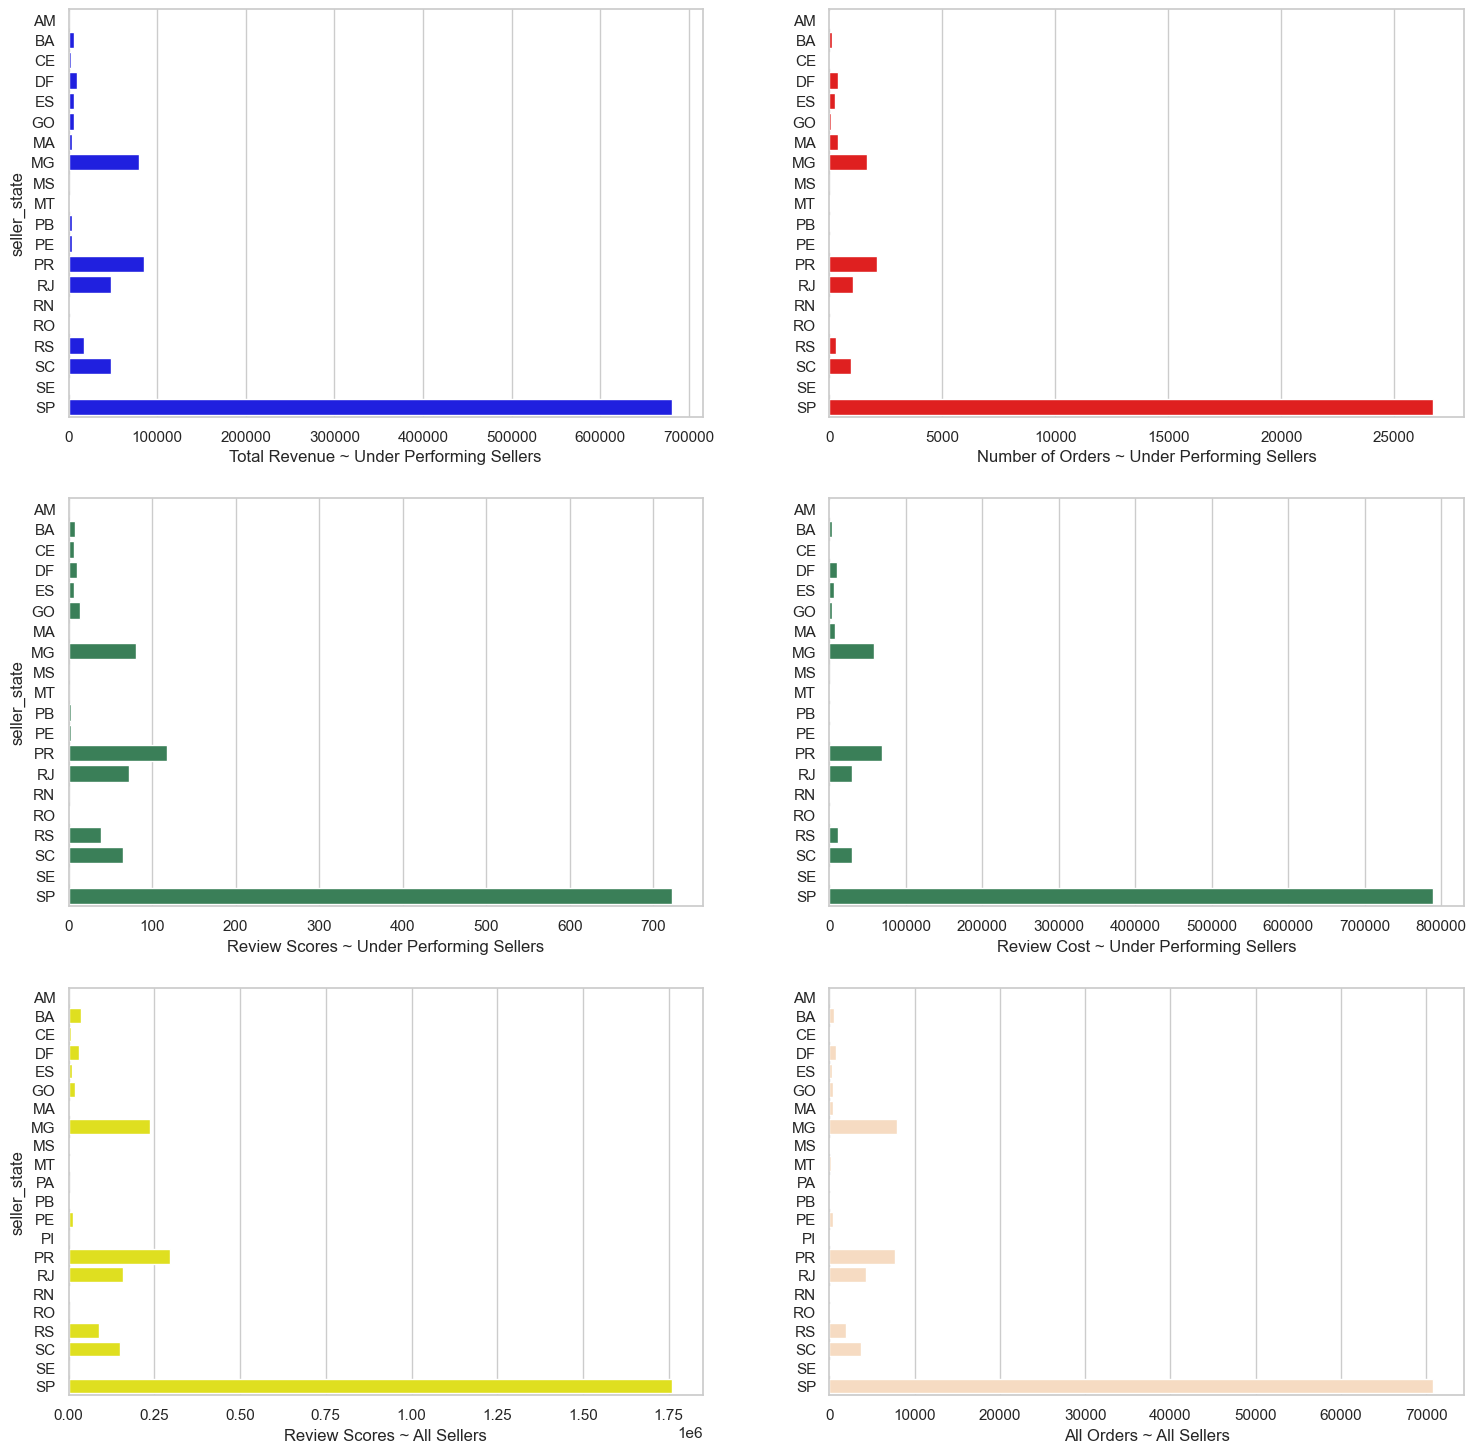

In [77]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(18, 18))

sns.set_color_codes("pastel")
sns.barplot(x="total_revenue",
            y="seller_state",
            data=df_merged_cost_state,
            color="blue",
            ax=axes[0, 0])
axes[0, 0].set(xlabel='Total Revenue ~ Under Performing Sellers')

sns.barplot(x="n_orders",
            y="seller_state",
            data=revenue_sellers_score,
            color="red",
            ax=axes[0, 1])
axes[0, 1].set(xlabel='Number of Orders ~ Under Performing Sellers',
               ylabel=None)

sns.barplot(x="review_score",
            y="seller_state",
            data=df_merged_cost_state,
            color="seagreen",
            ax=axes[1, 0])
axes[1, 0].set(xlabel='Review Scores ~ Under Performing Sellers')

sns.barplot(x="review_cost_x",
            y="seller_state",
            data=df_merged_cost_state,
            color="seagreen",
            ax=axes[1, 1])
axes[1, 1].set(xlabel='Review Cost ~ Under Performing Sellers', ylabel=None)

sns.barplot(x="total_revenue",
            y="seller_state",
            data=df_merged_allcost_state,
            color="yellow",
            ax=axes[2, 0])
axes[2, 0].set(xlabel='Review Scores ~ All Sellers')

sns.barplot(x="n_orders",
            y="seller_state",
            data=revenue_allsellers_score,
            color="peachpuff",
            ax=axes[2, 1])
axes[2, 1].set(xlabel='All Orders ~ All Sellers', ylabel=None)
plt.show()

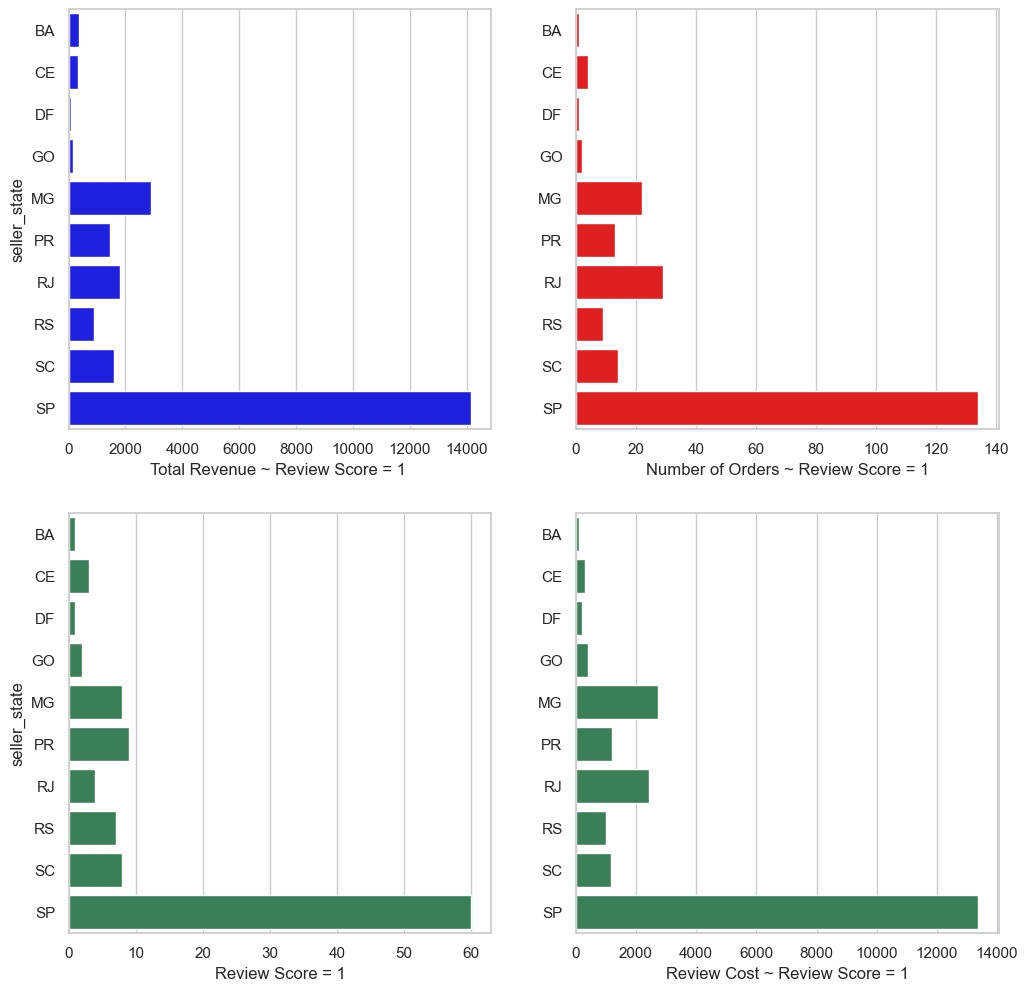

In [78]:
# Initialize the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.set_color_codes("pastel")
sns.barplot(x="total_revenue",
            y="seller_state",
            data=df_merged_cost_state_1,
            color="blue",
            ax=axes[0, 0])
axes[0, 0].set(xlabel='Total Revenue ~ Review Score = 1 ')

sns.barplot(x="n_orders",
            y="seller_state",
            data=revenue_sellers_score_1,
            color="red",
            ax=axes[0, 1])
axes[0, 1].set(xlabel='Number of Orders ~ Review Score = 1', ylabel=None)

sns.barplot(x="review_score",
            y="seller_state",
            data=df_merged_cost_state_1,
            color="seagreen",
            ax=axes[1, 0])
axes[1, 0].set(xlabel='Review Score = 1')

sns.barplot(x="review_cost_x",
            y="seller_state",
            data=df_merged_cost_state_1,
            color="seagreen",
            ax=axes[1, 1])
axes[1, 1].set(xlabel='Review Cost ~ Review Score = 1', ylabel=None)
plt.show()

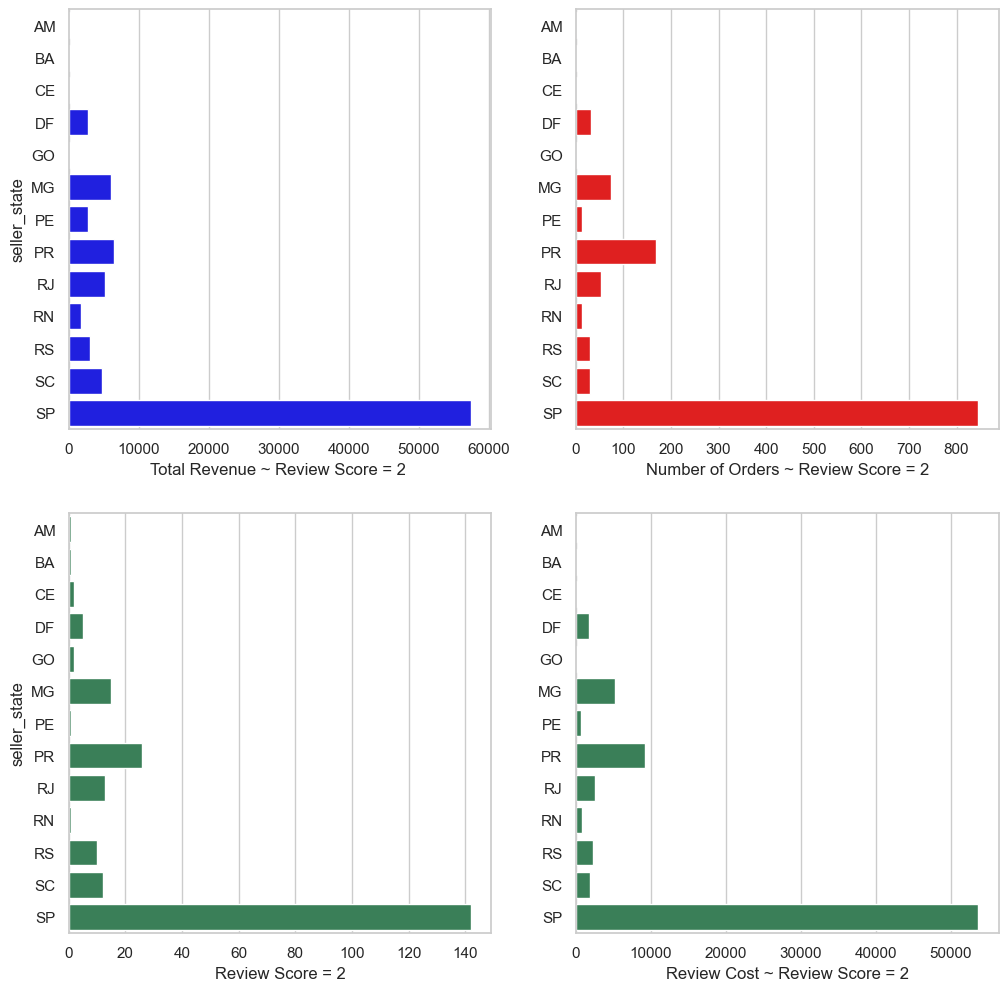

In [79]:
# Initialize the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.set_color_codes("pastel")
sns.barplot(x="total_revenue",
            y="seller_state",
            data=df_merged_cost_state_2,
            color="blue",
            ax=axes[0, 0])
axes[0, 0].set(xlabel='Total Revenue ~ Review Score = 2 ')

sns.barplot(x="n_orders",
            y="seller_state",
            data=revenue_sellers_score_2,
            color="red",
            ax=axes[0, 1])
axes[0, 1].set(xlabel='Number of Orders ~ Review Score = 2', ylabel=None)

sns.barplot(x="review_score",
            y="seller_state",
            data=df_merged_cost_state_2,
            color="seagreen",
            ax=axes[1, 0])
axes[1, 0].set(xlabel='Review Score = 2')

sns.barplot(x="review_cost_x",
            y="seller_state",
            data=df_merged_cost_state_2,
            color="seagreen",
            ax=axes[1, 1])
axes[1, 1].set(xlabel='Review Cost ~ Review Score = 2', ylabel=None)
plt.show()

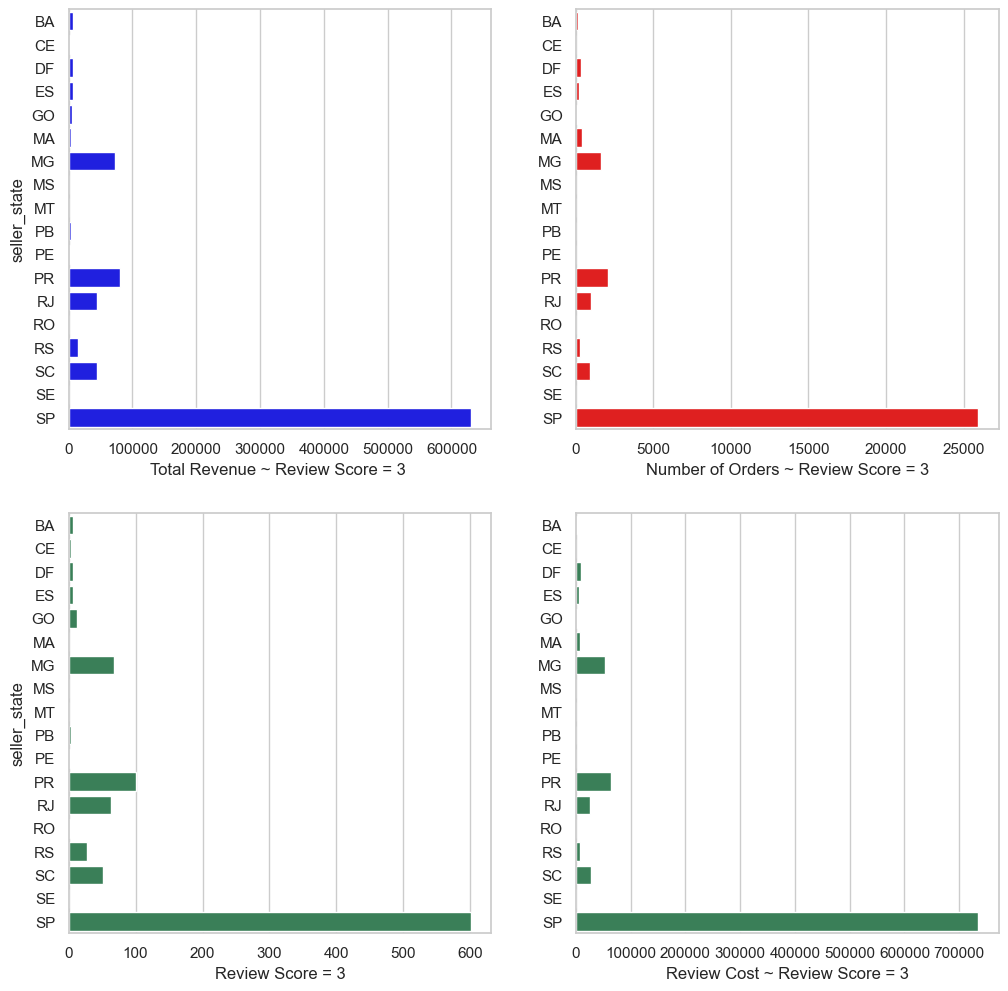

In [80]:
# Initialize the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.set_color_codes("pastel")
sns.barplot(x="total_revenue",
            y="seller_state",
            data=df_merged_cost_state_3,
            color="blue",
            ax=axes[0, 0])
axes[0, 0].set(xlabel='Total Revenue ~ Review Score = 3 ')

sns.barplot(x="n_orders",
            y="seller_state",
            data=revenue_sellers_score_3,
            color="red",
            ax=axes[0, 1])
axes[0, 1].set(xlabel='Number of Orders ~ Review Score = 3', ylabel=None)

sns.barplot(x="review_score",
            y="seller_state",
            data=df_merged_cost_state_3,
            color="seagreen",
            ax=axes[1, 0])
axes[1, 0].set(xlabel='Review Score = 3')

sns.barplot(x="review_cost_x",
            y="seller_state",
            data=df_merged_cost_state_3,
            color="seagreen",
            ax=axes[1, 1])
axes[1, 1].set(xlabel='Review Cost ~ Review Score = 3', ylabel=None)
plt.show()

In [88]:
df_SP_cities = df_sellers[df_sellers["seller_state"]=="SP"].groupby(["seller_city","seller_state"], as_index = False)["profits"].sum()\
.sort_values(by="profits").head(10)

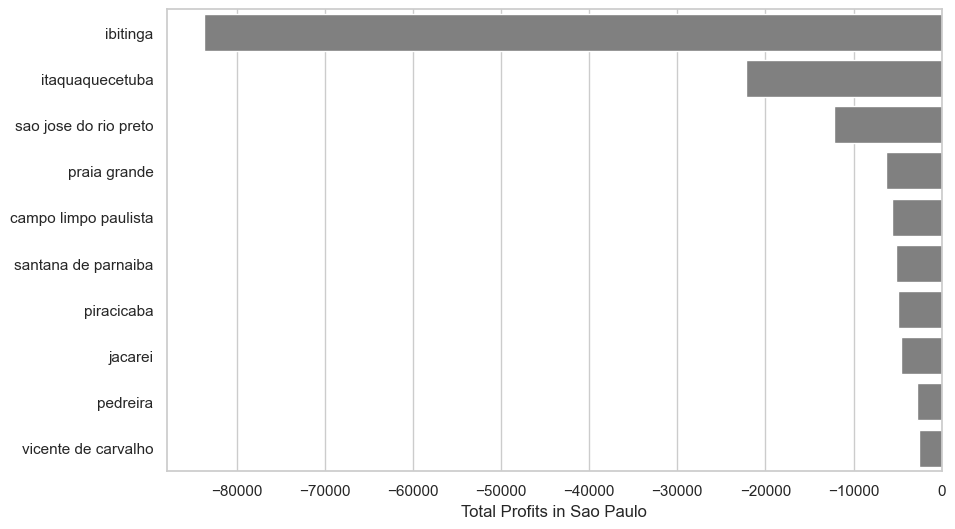

In [89]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

sns.set_color_codes("pastel")
sns.barplot(x="profits", y="seller_city", data=df_SP_cities, color="gray")
ax.set(xlabel='Total Profits in Sao Paulo', ylabel=None)

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [42]:
df_order_reviews = Order().get_review_score()

In [43]:
# number of sellers
df_sellers["seller_id"].nunique()

2967

**Cost of Reviews**

In [53]:
df_review_merged.columns

Index(['order_id', 'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'seller_id', 'review_cost'],
      dtype='object')

In [52]:
df_review_merged["review_cost"].sum()

2053340

In [46]:
df_order_sellers = data["order_items"][["order_id","seller_id"]]

In [47]:
df_review_merged = df_order_reviews.merge(df_order_sellers, on = "order_id", how="left")

df_review_merged["review_cost"] = df_review_merged["review_score"].map({1: 100, 2: 50, 3: 40, 4: 0, 5: 0})

df_review_grouped = df_review_merged.groupby('seller_id').sum()[['review_cost']]



In [51]:
"{:,.2f} BRL".format(df_sellers["review_cost"].sum())

'1,976,650.00 BRL'

**Total Revenue**

In [49]:
df_sellers = df_sellers.merge(df_review_grouped, on='seller_id', how='left')
"{:,.2f} BRL".format(df_sellers['total_revenue'].sum())

'2,835,578.44 BRL'

**Profits = Total Revenue - Cost of Reviews**

In [50]:
df_sellers['profits'] = df_sellers['total_revenue'] - df_sellers["review_cost"]

"{:,.2f} BRL".format(df_sellers["profits"].sum())

'858,928.44 BRL'

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪